# Explore embeddings

Load and explore embeddings from different methods


Install required packages:
```
uv add pyarrow nbformat plotly
```

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

Load embeddings

In [2]:
from pathlib import Path

basepath = Path("../data/embeddings/")

movie_embeddings_dfs = {
    filepath.name.split(".")[0]: pl.read_parquet(filepath)
    for filepath in basepath.glob("**/*")
}

if 0:
    movie_embeddings_dfs = pl.concat(
        [
            pl.read_parquet(filepath).with_columns(
                name=pl.lit(filepath.name.split(".")[0])
            )
            for filepath in basepath.glob("**/*")
        ],
        how="vertical_relaxed",
    )

movie_embeddings_dfs

{'word2vec_20': shape: (50, 21)
 ┌─────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ movieId ┆ column_0  ┆ column_1  ┆ column_2  ┆ … ┆ column_16 ┆ column_17 ┆ column_18 ┆ column_19 │
 │ ---     ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ i64     ┆ f32       ┆ f32       ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
 ╞═════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 1       ┆ 0.170268  ┆ 0.005285  ┆ 0.173711  ┆ … ┆ -0.195489 ┆ -0.429596 ┆ 0.263023  ┆ 0.047042  │
 │ 32      ┆ -0.508879 ┆ -0.034648 ┆ -0.601913 ┆ … ┆ -0.543937 ┆ -0.180518 ┆ -0.055841 ┆ 0.024215  │
 │ 47      ┆ -0.031499 ┆ 0.355408  ┆ -0.286842 ┆ … ┆ 0.356284  ┆ 0.213535  ┆ -0.142556 ┆ 0.032458  │
 │ 50      ┆ -0.324363 ┆ 0.060988  ┆ 0.007004  ┆ … ┆ -0.237505 ┆ 0.496448  ┆ -0.316936 ┆ 0.07419   │
 │ 110     ┆ 0.246857  ┆ -0.459349 ┆ 0.304814  ┆ … ┆ -0.408

In [3]:
ratings_df = utilities.load_ratings()
movies_df = utilities.load_movies()
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
top_movies_df = movies_df.join(top_movie_ids, on="movieId")
labels = top_movies_df["title"].to_list()
top_movies_df

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Mystery|Sci-Fi|Thriller"""
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller"""
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller"""
110,"""Braveheart (1995)""","""Action|Drama|War"""
…,…,…
4993,"""Lord of the Rings: The Fellows…","""Adventure|Fantasy"""
5952,"""Lord of the Rings: The Two Tow…","""Adventure|Fantasy"""
7153,"""Lord of the Rings: The Return …","""Action|Adventure|Drama|Fantasy"""


### Cosine similarity

Use cosine similarity on embedding pairs to find similar titles.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity


def get_embedding_vectors(movie_embeddings_df: pl.DataFrame) -> np.array:
    # limit to top movies only
    return (
        top_movies_df["movieId", "title"]
        .join(movie_embeddings_df, on="movieId", how="left")
        .drop(["movieId", "title"])
        .to_numpy()
    )


def get_cosine_similarities(
    movie_embeddings_df: pl.DataFrame, lower_triangle: bool = True
) -> np.array:
    embedding_values = get_embedding_vectors(movie_embeddings_df)

    similarity_matrix = cosine_similarity(embedding_values)
    # limit to lower triangle only
    if lower_triangle:
        similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k=0)] = np.nan

    return similarity_matrix

The strongest and weakest similarities:

In [5]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)
    utilities.get_extreme_similarities(
        similarity_matrix=similarity_matrix, labels=labels, top_n=10
    )
    print()

word2vec_20
Most similar:
0.56 - Memento (2000), Fight Club (1999)
0.51 - Indiana Jones and the Last Crusade (1989), Princess Bride, The (1987)
0.50 - Sixth Sense, The (1999), Good Will Hunting (1997)
0.50 - Sixth Sense, The (1999), Godfather, The (1972)
0.47 - Aladdin (1992), Seven (a.k.a. Se7en) (1995)
0.46 - Lord of the Rings: The Fellowship of the Ring, The (2001), Memento (2000)
0.46 - Independence Day (a.k.a. ID4) (1996), Aladdin (1992)
0.46 - Aladdin (1992), Speed (1994)
0.45 - Fargo (1996), Ace Ventura: Pet Detective (1994)
0.44 - American Beauty (1999), Usual Suspects, The (1995)

Least similar:
-0.60 - Inception (2010), Lion King, The (1994)
-0.56 - Dark Knight, The (2008), Aladdin (1992)
-0.55 - Indiana Jones and the Last Crusade (1989), Fargo (1996)
-0.54 - Titanic (1997), Schindler's List (1993)
-0.54 - Dark Knight, The (2008), Men in Black (a.k.a. MIB) (1997)
-0.53 - Groundhog Day (1993), Shawshank Redemption, The (1994)
-0.53 - Inception (2010), Independence Day (a.k.a. 

Plotting similarities for all 50x50 pairs:

word2vec_20
word2vec


/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tf_idf
nn


/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/utilities.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


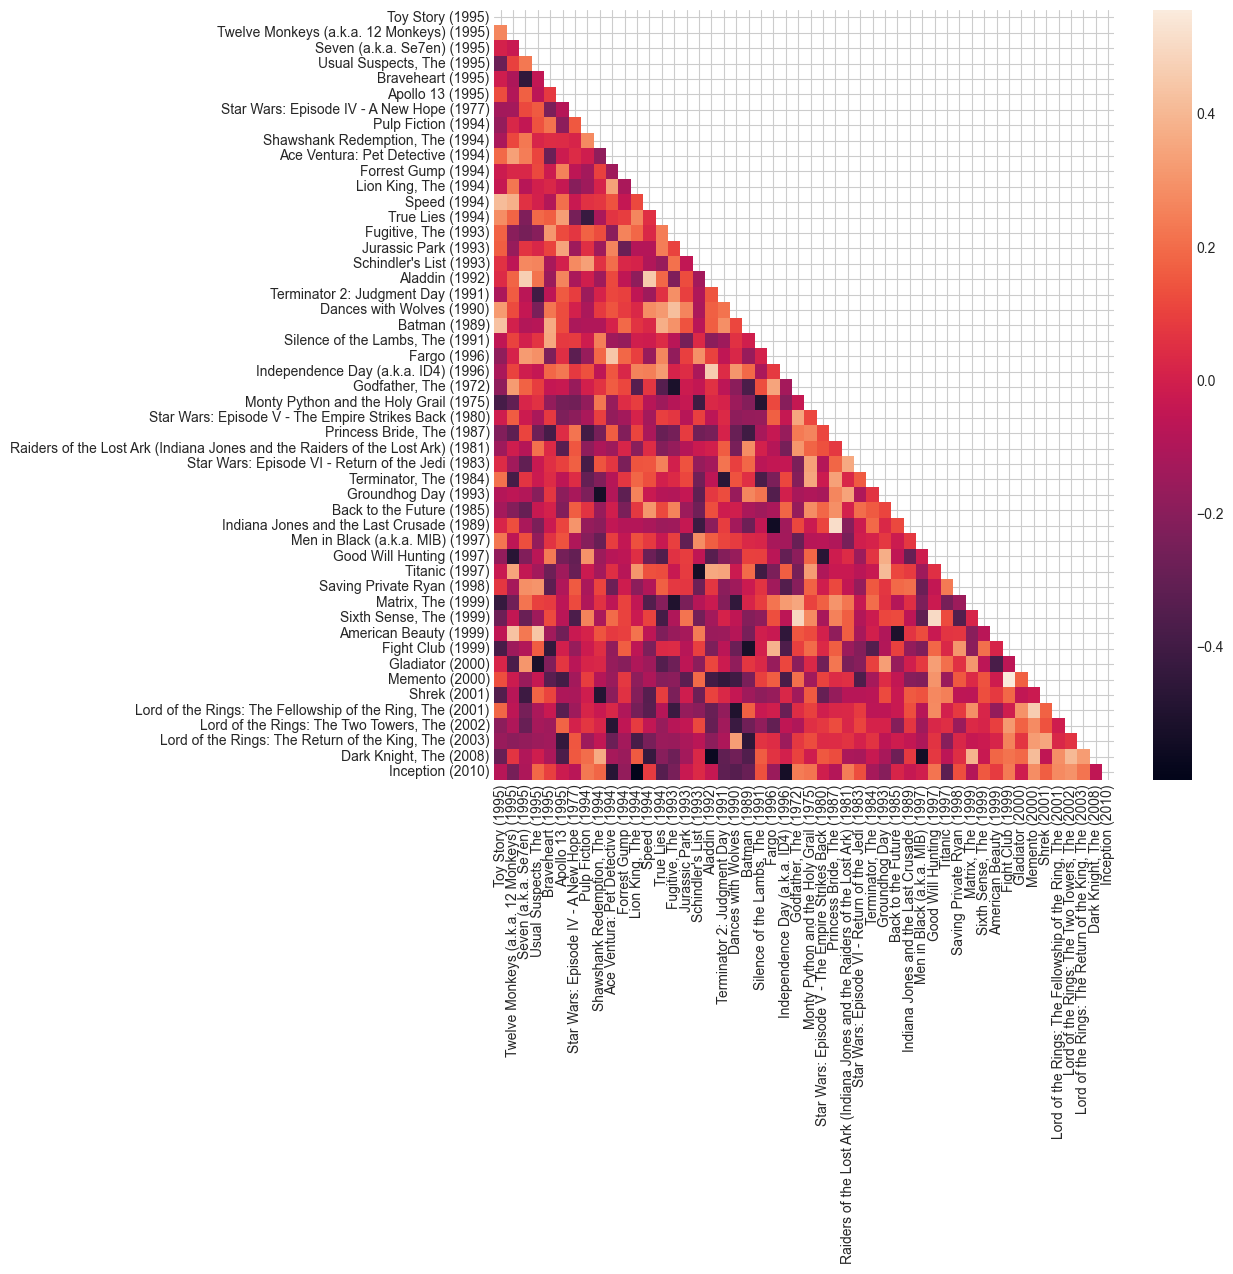

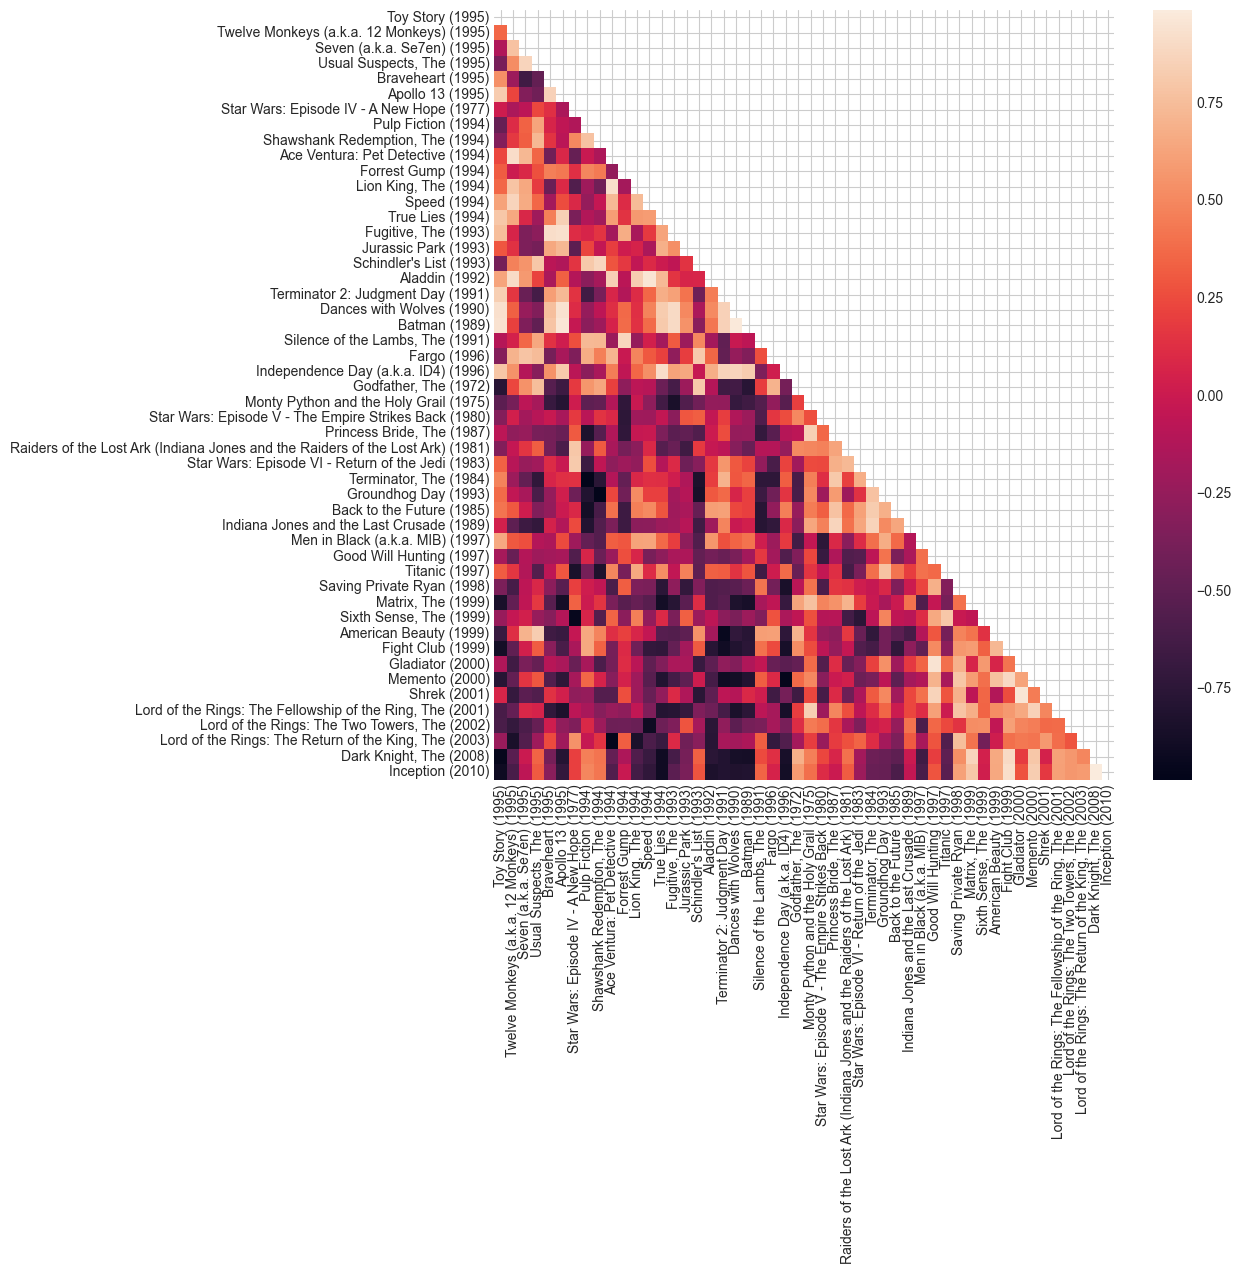

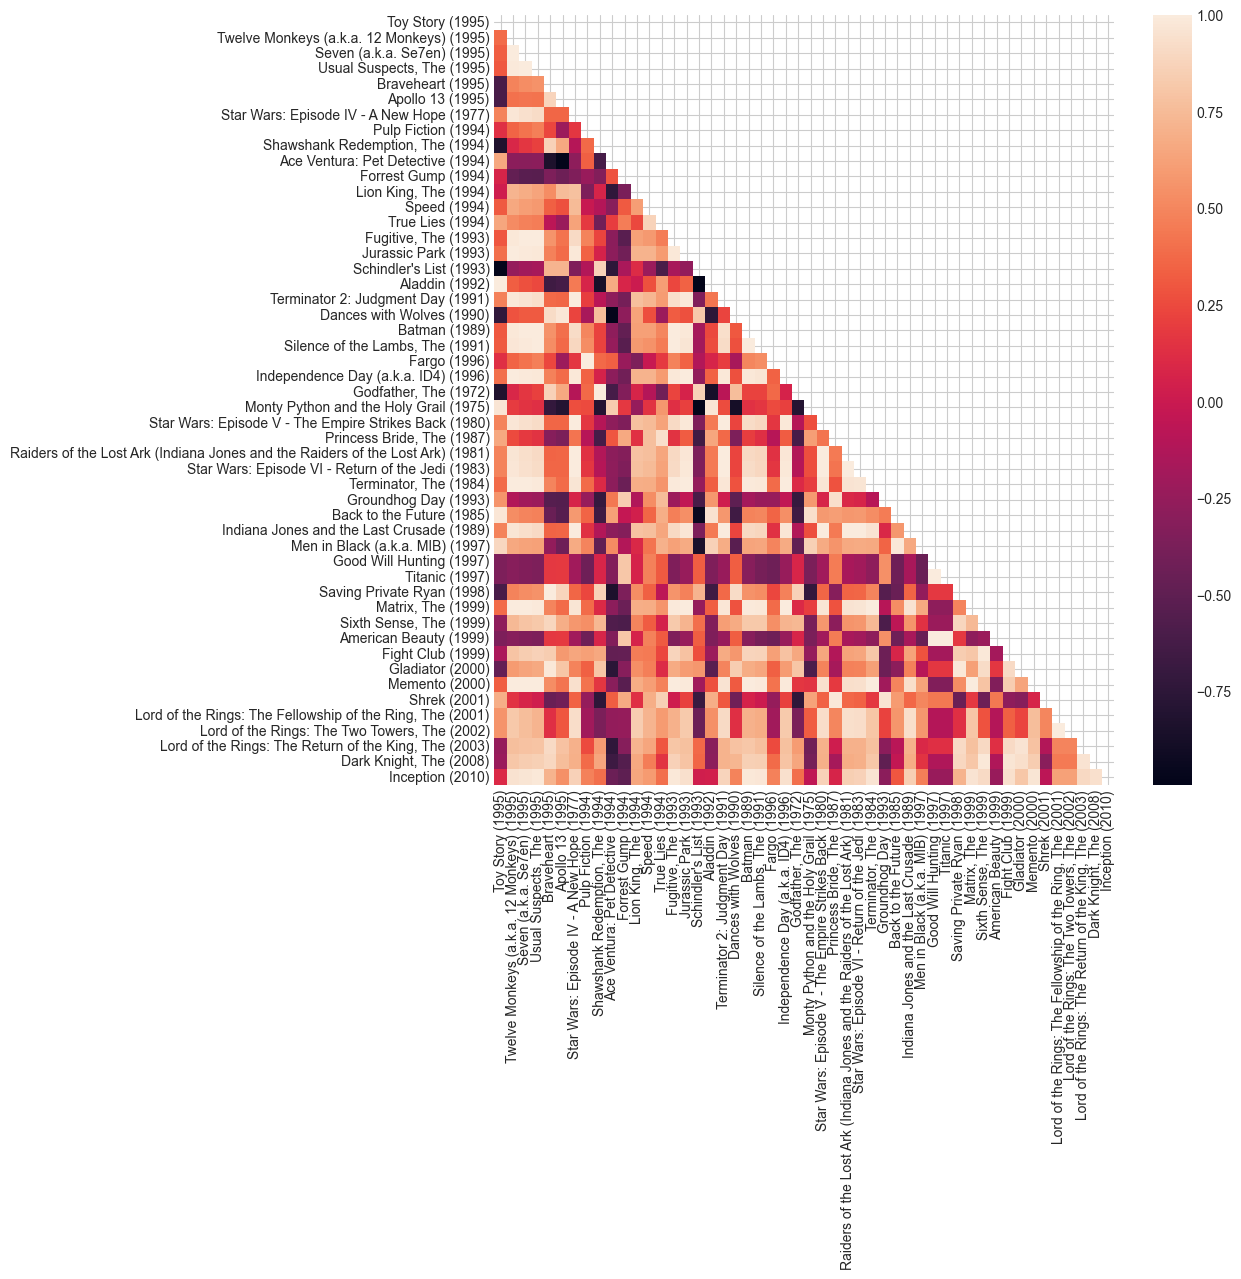

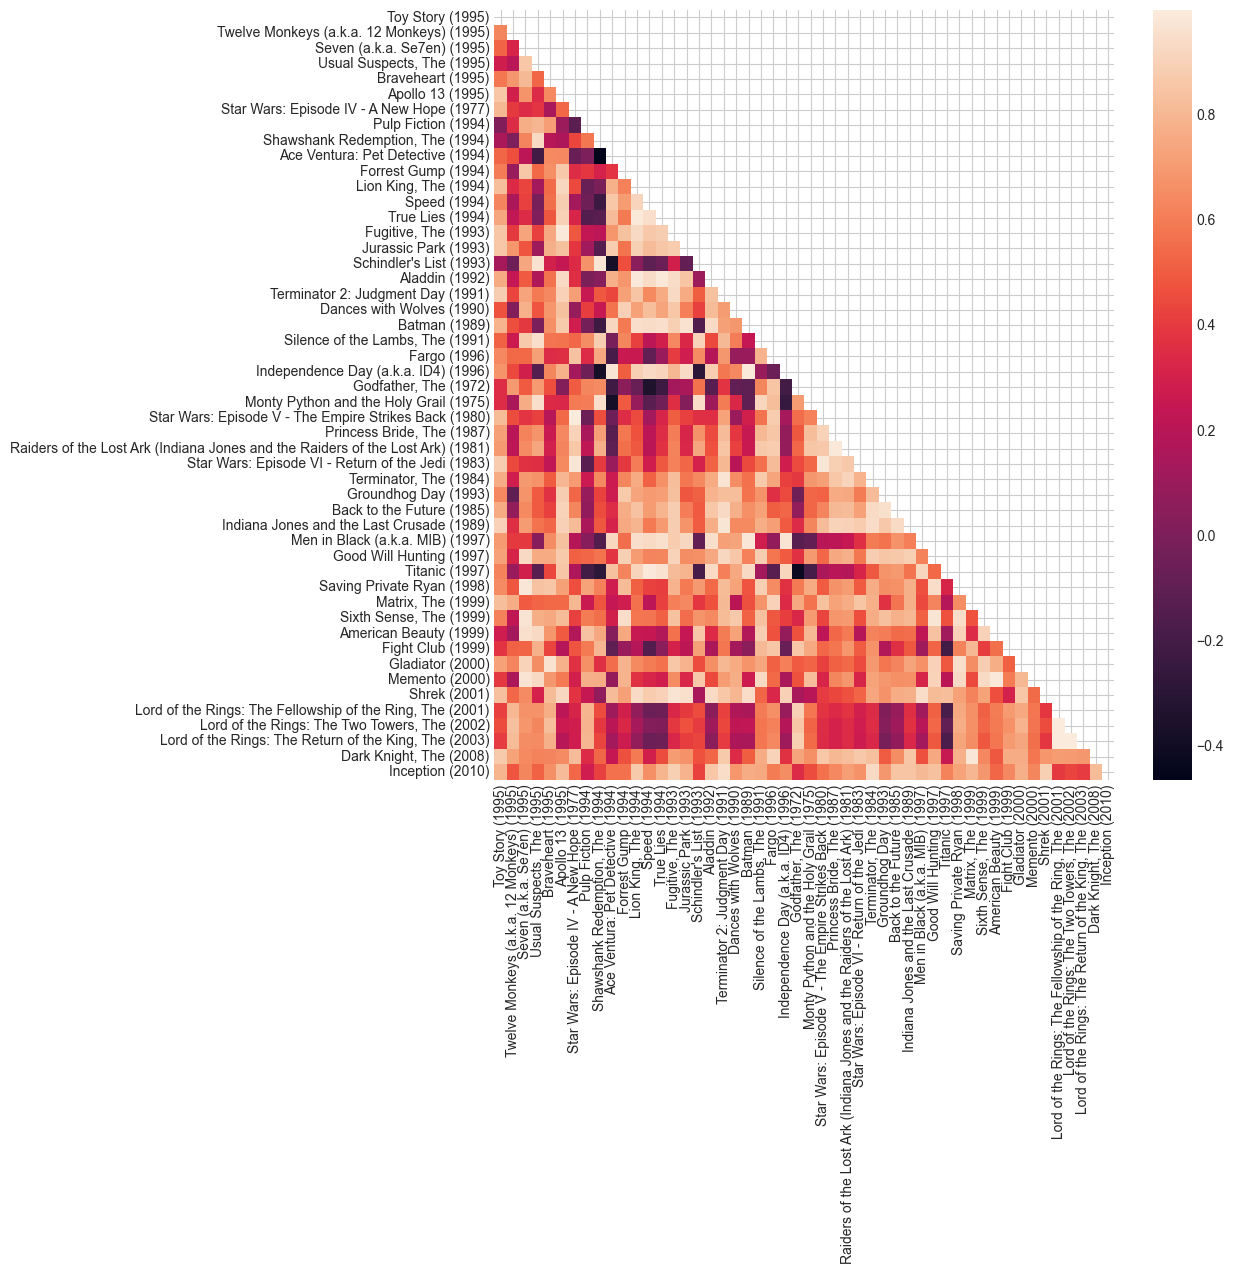

In [6]:
for name, movie_embeddings_df in movie_embeddings_dfs.items():
    print(name)
    similarity_matrix = get_cosine_similarities(movie_embeddings_df)

    utilities.plot_similarities(similarity_matrix=similarity_matrix, labels=labels)

### T-SNE clusters

In [7]:
import plotly.express as px
from sklearn.manifold import TSNE


def plot_tsne_scatter(movie_embeddings_df, name: str):
    tsne_df = top_movies_df["movieId", "title"].join(
        movie_embeddings_df, on="movieId", how="left"
    )

    embedding_vectors = tsne_df.drop(["movieId", "title"]).to_numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(embedding_vectors)
    tsne_df = tsne_df.with_columns(
        tsne_embeddings_0=tsne_embeddings[:, 0], tsne_embeddings_1=tsne_embeddings[:, 1]
    )

    fig = px.scatter(
        tsne_df.to_pandas(),
        x="tsne_embeddings_0",
        y="tsne_embeddings_1",
        hover_data=["title"],
        height=800,
        width=1000,
        template="seaborn",
        text="title",
        title=f"Embedding TSNE - {name}",
    )
    fig.show()


# plot_tsne_scatter(movie_embeddings_dfs["word2vec"], "word2vec")
# plot_tsne_scatter(movie_embeddings_dfs["tf_idf"], "tf-idf")
plot_tsne_scatter(movie_embeddings_dfs["nn"], "nn")

In [8]:
plot_tsne_scatter(movie_embeddings_dfs["word2vec_20"], "word2vec_20")

Hierarchical clusters

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_67250/1913525207.py:22: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



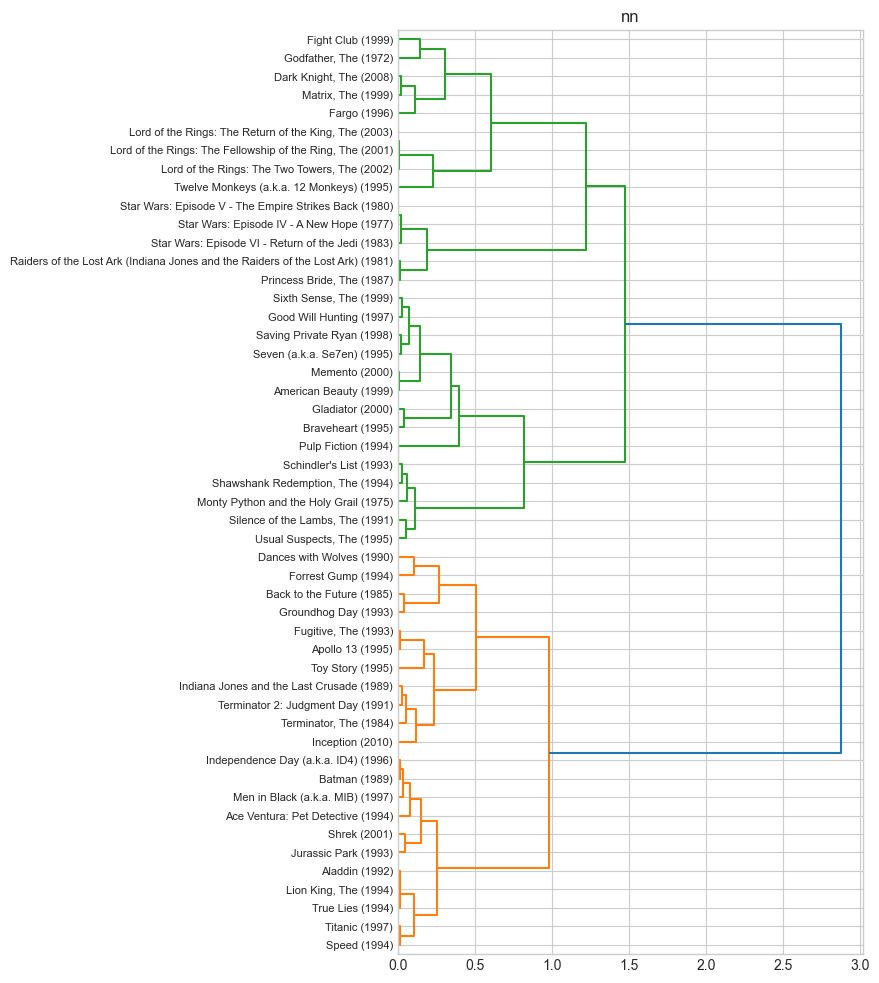

In [9]:
import scipy.spatial.distance
import scipy.cluster


def plot_hierarchical_clusters(movie_embeddings_df, name: str):
    similarity_matrix = get_cosine_similarities(
        movie_embeddings_df, lower_triangle=False
    )
    distance_matrix = 1 - similarity_matrix

    np.fill_diagonal(distance_matrix, 0)
    dist_linkage = scipy.cluster.hierarchy.ward(
        scipy.spatial.distance.squareform(distance_matrix)
    )

    # fig, ax = plt.subplots(figsize=(10, 30), dpi=200)
    fig, ax = plt.subplots(figsize=(6, 12))
    _ = scipy.cluster.hierarchy.dendrogram(
        dist_linkage, labels=labels, ax=ax, orientation="right"
    )
    ax.set(title=name)
    fig.show()


plot_hierarchical_clusters(movie_embeddings_dfs["nn"], "nn")